<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/Sartorius-Cell-Instance-Segmentation/Sartorius_Cell_Instance_Segmentation_Training_(Mask_R_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sartorius - Cell Instance Segmentation
## Detect single neuronal cells in microscopy images

* 학습용 이미지 606개
* 학습용 annotation mask는 Run-Length encoded되어 csv파일로 제공

##Files
train.csv - IDs and masks for all training objects. None of this metadata is provided for the test set.

* id - unique identifier for object

* annotation - run length encoded pixels for the identified neuronal cell

* width - source image width

* height - source image height

* cell_type - the cell line

* plate_time - time plate was created

* sample_date - date sample was created

* sample_id - sample identifier

* elapsed_timedelta - time since first image taken of sample

##1. MMDetection 설치

In [1]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 68.5 MB 30.9 MB/s 
     |████████████████████████████████| 190 kB 4.1 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 23137, done.
remote: Total 23137 (delta 0), reused 0 (delta 0), pack-reused 23137
Receiving objects: 100% (23137/23137), 25.87 MiB | 12.63 MiB/s, done.
Resolving deltas: 100% (16199/16199), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_

In [2]:
# 런타임->런타임 다시 시작 후 아래 수행. 
from mmdet.apis import init_detector, inference_detector
import mmcv

In [3]:
!mkdir cell; mkdir cell/train

#2. Cell Dataset 다운로드 및 탐색

In [ ]:
!unzip /content/drive/MyDrive/cell-instance-segmentation/train.zip -d cell/train

In [5]:
# 전체 이미지 데이터 갯수 출력
import glob
len(glob.glob('cell/train/*.png'))

606

In [7]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


### annotated된 오브젝트는 73585개

In [8]:
df.shape[0]

73585

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


In [10]:
from sklearn.model_selection import train_test_split

#전체 이미지를 train용과 validation용으로 나눈다.
imgs = [img.split('/')[-1] for img in glob.glob('cell/train/*.png')]
tr_imgs, val_imgs = train_test_split(imgs, test_size = 0.1, random_state = 42)
len(tr_imgs), len(val_imgs)

(545, 61)

In [11]:
# 전체 이미지에서 id값이 validation 용 이미지에 포함되어있다면 제거하고 train dataframe으로 저장
df_train = df.copy()
df_train.shape[0]
for i in val_imgs:
  idx = df_train['id'] == i[:-4]
  df_train.drop(index = df_train[idx].index, axis = 0, inplace = True)


In [12]:
df_train.shape[0]

65011

In [13]:
# 원래 dataframe의 칼럼을 가지는 비어있는 dataframe 생성
df_val = pd.DataFrame(columns = df.columns)

# 전체이미지들중에서 id가 validation용에 포함된다면 validation dataframe에 추가
for i in val_imgs:
  df_val = pd.concat([df_val, df[df['id'] == i[:-4]]])

In [14]:
df_val.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
42915,930699898b1c,306552 2 307256 4 307959 7 308664 8 309368 10 ...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D3-4_Vessel-714_Ph_4,0 days 11:30:00
42916,930699898b1c,279018 3 279722 5 280426 6 281130 7 281834 7 2...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D3-4_Vessel-714_Ph_4,0 days 11:30:00
42917,930699898b1c,248771 2 249474 5 250178 5 250881 6 251584 7 2...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D3-4_Vessel-714_Ph_4,0 days 11:30:00
42918,930699898b1c,295234 2 295937 5 296640 7 297343 10 298047 12...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D3-4_Vessel-714_Ph_4,0 days 11:30:00
42919,930699898b1c,178036 3 178737 8 179439 11 180140 15 180841 1...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D3-4_Vessel-714_Ph_4,0 days 11:30:00


In [15]:
val_imgs[:5]

['930699898b1c.png',
 '4cf637b37b8b.png',
 '6b165d790e33.png',
 'b66e76eb1f3f.png',
 '3be8cce336d0.png']

In [16]:
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [17]:
sample_img = tr_imgs[0]
sample_annotation = df_train[df_train.id == sample_img[:-4]].annotation

In [18]:
# 샘플 이미지의 object segmentation 정보 출력
sample_annotation

31334    111347 5 112051 7 112756 7 113460 8 114165 7 1...
31335    288771 1 289473 4 290176 5 290880 6 291585 6 2...
31336    81000 10 81689 3 81699 16 82391 2 82396 2 8240...
31337    254632 4 255334 9 256036 12 256736 16 257436 2...
31338    339754 2 340457 6 341161 8 341864 9 342568 8 3...
31339    202778 11 203481 13 204173 25 204876 28 205580...
31340    41114 3 41817 4 42521 5 43224 6 43928 6 44631 ...
31341    101048 5 101749 8 102450 10 103151 13 103852 1...
31342    262329 3 263027 10 263727 14 264429 16 265131 ...
31343    68010 4 68713 6 69416 8 70120 9 70824 10 71529...
31344    155116 4 155819 5 156522 7 157224 9 157927 10 ...
31345    125511 9 126212 14 126911 20 127610 25 128314 ...
31346    291139 4 291842 5 292546 5 293249 7 293953 7 2...
31347    117864 2 118567 4 119270 5 119974 5 120677 7 1...
31348    88887 1 89589 3 90291 5 90994 6 91698 5 92401 ...
Name: annotation, dtype: object

##2.2 샘플 이미지 Segmentation 정보 시각화

In [19]:
import cv2
import os
img_path = os.path.join('/content/cell/train', sample_img)
img = cv2.imread(img_path)

In [20]:
img.shape

(520, 704, 3)

In [21]:
import numpy as np
h, w = img.shape[:2]
mask = np.zeros(w * h, dtype = np.uint32)
mask.shape

(366080,)

In [22]:
# 오브젝트 하나 시각화
img_encoded_mask = list(map(int,sample_annotation.values[0].split()))
mask_start = img_encoded_mask[0::2]
mask_length = img_encoded_mask[1::2]
len(mask_start), len(mask_length)

(129, 129)

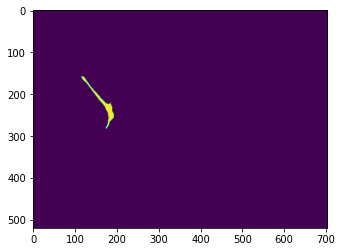

In [23]:
import matplotlib.pyplot as plt

for s, l in zip(mask_start, mask_length):
  mask[s:s+l] = 255
mask_2 = mask.reshape((h, w))
plt.imshow(mask_2)

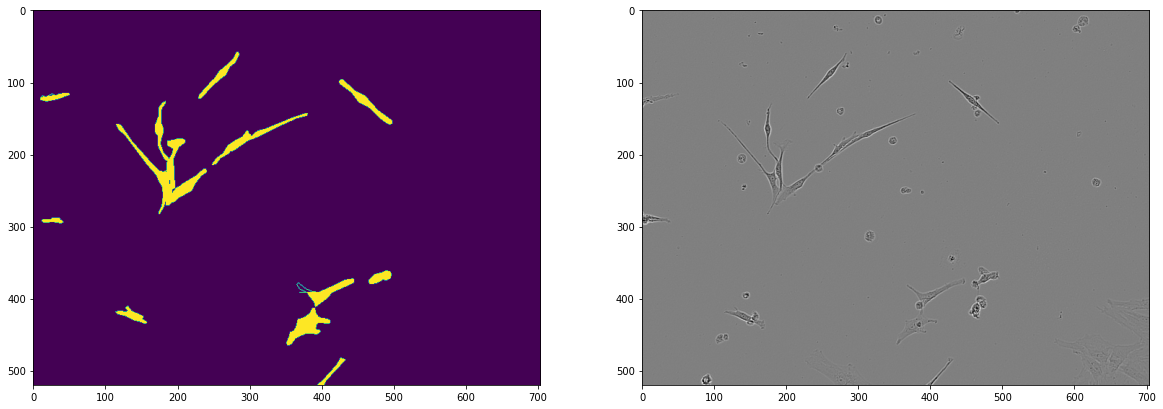

In [24]:
mask = np.zeros(w * h, dtype = np.uint32)
num_obj = len(sample_annotation.index)
for i in range(len(sample_annotation.index)):
  img_encoded_mask = list(map(int,sample_annotation.values[i].split()))
  mask_start = img_encoded_mask[0::2]
  mask_length = img_encoded_mask[1::2]
  for s, l in zip(mask_start, mask_length):
    mask[s:s+l] = 255

mask_2 = mask.reshape((h, w))

plt.figure(figsize = (20, 20))
plt.subplot(1, 2, 1)
plt.imshow(mask_2);

plt.subplot(1, 2, 2)
plt.imshow(img);

(-0.5, 703.5, 519.5, -0.5)

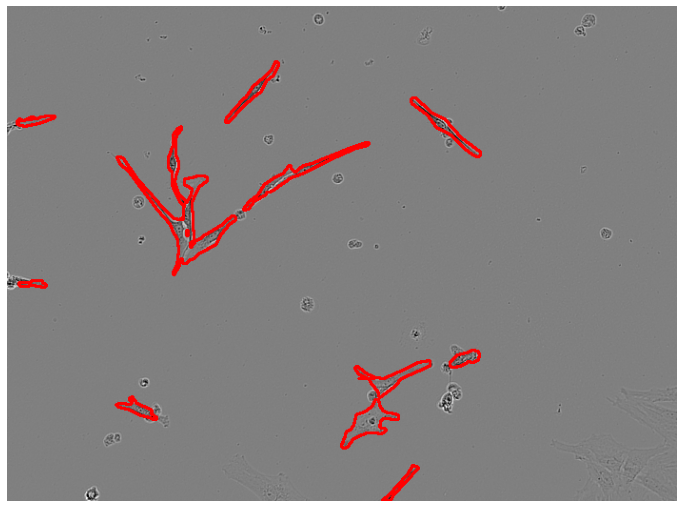

In [25]:
mask = np.array(mask_2, dtype = np.uint8)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
masked_image = cv2.drawContours(img, contours, -1, color = (255, 0, 0), thickness = 2, 
                                lineType = cv2.LINE_8,
                                hierarchy = hierarchy,
                                maxLevel = 100)

plt.figure(figsize = (12, 14))
plt.imshow(masked_image)
plt.axis('off')

In [26]:
CLASS_NAMES = list(df.cell_type.value_counts().index)

In [27]:
df_train_2 = df_train.drop(columns = ['plate_time', 'sample_date', 'sample_id', 'elapsed_timedelta'], axis = 1)
df_val_2 = df_val.drop(columns = ['plate_time', 'sample_date', 'sample_id', 'elapsed_timedelta'], axis = 1)

In [28]:
df_val_2.head()

,id,annotation,width,height,cell_type
42915,930699898b1c,306552 2 307256 4 307959 7 308664 8 309368 10 ...,704,520,shsy5y
42916,930699898b1c,279018 3 279722 5 280426 6 281130 7 281834 7 2...,704,520,shsy5y
42917,930699898b1c,248771 2 249474 5 250178 5 250881 6 251584 7 2...,704,520,shsy5y
42918,930699898b1c,295234 2 295937 5 296640 7 297343 10 298047 12...,704,520,shsy5y
42919,930699898b1c,178036 3 178737 8 179439 11 180140 15 180841 1...,704,520,shsy5y


In [29]:
CLASS_NAMES.index('cort')

1

In [30]:
CLASS_NAMES

['shsy5y', 'cort', 'astro']

In [31]:
!mkdir /content/cell/val

In [32]:
import shutil

for img in val_imgs:
  src = os.path.join('/content/cell/train', img)
  shutil.move(src, os.path.join('/content/cell/val', img))

In [66]:
import os.path as osp
import json
from tqdm.notebook import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder

# json을 coco json 형태로 변환
def convert_to_coco(ann_df, out_file, image_prefix):
  ''' ann_df은 metadata dataframe, out_file은 coco로 변환할 출력 json파일
      image_prefix는 image png가 있는 디렉토리 위치 
  '''

  # coco의 주요 key값인 annotations와 images를 담을 list 생성. 
  annotations = []
  images = []
  obj_count = 0

  le = LabelEncoder()
  image_id_encoded = le.fit_transform(ann_df.id)
  ann_df['image_id_encoded'] = image_id_encoded

  img_id_list = ann_df['id'].drop_duplicates().values
  for image_id in img_id_list:
    img_path = os.path.join(image_prefix, image_id + '.png')
    height, width = cv2.imread(img_path).shape[:2]
    img_id = int(le.transform([image_id])[0])
    
    images.append(dict(
        id = img_id,
        file_name = image_id + '.png',
        height = height,
        width = width
    ))

  for idx, (image_id, pixels, width, height, cell_type, image_id_encoded) in ann_df.iterrows():

    pixels = pixels.split()
    pixels = np.array(pixels, dtype = int)
    pixels = pixels.reshape(-1, 2)

    img_path = os.path.join(image_prefix, image_id + '.png')
    mask = np.zeros(height * width)

    for start, length in pixels:
      mask[start : start + length] = 255
    
    mask = mask.reshape((height, width))
    mask = np.array(mask, dtype = np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for i in range(len(contours)):
      
      if len(contours[i]) > 2:
        poly = np.squeeze(contours[i])
        x_min, y_min, x_max, y_max = int(min(poly[:, 0])), int(min(poly[:, 1])), int(max(poly[:, 0])), int(max(poly[:, 1]))
        poly = list(poly.flatten())
        poly = [int(x) for x in poly]
        data_anno = dict(
              image_id = image_id_encoded,
              id=obj_count,
              category_id = CLASS_NAMES.index(cell_type),
              bbox = [x_min, y_min, x_max - x_min, y_max - y_min],
              area = (x_max - x_min) * (y_max - y_min),
              segmentation = [poly],
              iscrowd = 0
          )
        annotations.append(data_anno)
        obj_count += 1

  # images와 annotations, categories를 Dict형태로 저장. 
  coco_format_json = dict(
      images = images,
      annotations = annotations,
      categories = [{'id':0, 'name':CLASS_NAMES[0]},
                    {'id':1, 'name':CLASS_NAMES[1]},
                    {'id':2, 'name':CLASS_NAMES[2]}]
  )
  
  # json 파일로 출력. 
  #mmcv.dump(coco_format_json, out_file)
  with open(out_file, 'w') as json_out_file:
    json.dump(coco_format_json, json_out_file)
    

In [67]:
convert_to_coco(df_train_2, '/content/cell/train.json', '/content/cell/train')

In [68]:
convert_to_coco(df_val_2, '/content/cell/val.json', '/content/cell/val')

pycocotools를 이용하여 변환된 coco json의 segmentation 시각화
* coco format으로 잘 변환 되었는지 확인하기 위해 pycocotools로 특정 image id의 image filename 및 segmentation 정보를 추출하고 이를 시각화

In [70]:
from pycocotools.coco import COCO

coco = COCO('/content/cell/train.json')

loading annotations into memory...
Done (t=12.21s)
creating index...
index created!


In [71]:
catIds = coco.getCatIds(catNms = [CLASS_NAMES[1]])
catIds

[1]

In [72]:
imgIds = coco.getImgIds(catIds = catIds)
img = coco.loadImgs(imgIds[0])[0]
print(img)
annIds = coco.getAnnIds(imgIds = img['id'], catIds = [0,1,2], iscrowd = False)
anns = coco.loadAnns(annIds)
print(anns)

{'id': 512, 'file_name': 'ee6d4d0a17b6.png', 'height': 520, 'width': 704}
[{'image_id': 512, 'id': 68234, 'category_id': 1, 'bbox': [627, 236, 21, 16], 'area': 336, 'segmentation': [[632, 236, 631, 237, 630, 237, 628, 239, 628, 240, 627, 241, 627, 248, 629, 250, 630, 250, 631, 251, 632, 251, 633, 252, 635, 252, 636, 251, 638, 251, 640, 249, 640, 247, 641, 246, 642, 246, 644, 244, 645, 244, 648, 241, 648, 239, 647, 239, 645, 237, 636, 237, 635, 236]], 'iscrowd': 0}, {'image_id': 512, 'id': 68235, 'category_id': 1, 'bbox': [198, 284, 12, 15], 'area': 180, 'segmentation': [[205, 284, 204, 285, 203, 285, 201, 287, 200, 287, 200, 288, 199, 289, 199, 295, 198, 296, 198, 297, 200, 299, 201, 299, 202, 298, 204, 298, 207, 295, 207, 294, 209, 292, 209, 291, 210, 290, 210, 288, 209, 287, 209, 286, 207, 284]], 'iscrowd': 0}, {'image_id': 512, 'id': 68236, 'category_id': 1, 'bbox': [65, 494, 16, 15], 'area': 240, 'segmentation': [[72, 494, 71, 495, 68, 495, 65, 498, 65, 503, 66, 504, 66, 506, 67, 5

In [73]:
#segmentation 정보만 별도 추출
ann_seg_list = [ann['segmentation'][0] for ann in anns]
print(ann_seg_list)

[[632, 236, 631, 237, 630, 237, 628, 239, 628, 240, 627, 241, 627, 248, 629, 250, 630, 250, 631, 251, 632, 251, 633, 252, 635, 252, 636, 251, 638, 251, 640, 249, 640, 247, 641, 246, 642, 246, 644, 244, 645, 244, 648, 241, 648, 239, 647, 239, 645, 237, 636, 237, 635, 236], [205, 284, 204, 285, 203, 285, 201, 287, 200, 287, 200, 288, 199, 289, 199, 295, 198, 296, 198, 297, 200, 299, 201, 299, 202, 298, 204, 298, 207, 295, 207, 294, 209, 292, 209, 291, 210, 290, 210, 288, 209, 287, 209, 286, 207, 284], [72, 494, 71, 495, 68, 495, 65, 498, 65, 503, 66, 504, 66, 506, 67, 507, 68, 507, 69, 508, 70, 508, 71, 509, 72, 509, 74, 507, 74, 506, 81, 499, 81, 497, 79, 495, 77, 495, 76, 494], [467, 419, 466, 420, 464, 420, 462, 422, 462, 424, 461, 425, 461, 427, 462, 428, 462, 429, 463, 430, 464, 430, 467, 433, 468, 433, 469, 434, 470, 434, 471, 435, 478, 435, 481, 432, 481, 427, 480, 426, 480, 425, 479, 424, 478, 424, 475, 421, 474, 421, 473, 420, 470, 420, 469, 419], [182, 360, 178, 364, 178, 367, 

In [74]:
ann_cat_list = [ann['category_id'] for ann in anns]
print(ann_cat_list)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [75]:
def get_polygon_xy(ann_seg):
  polygon_x = [x for index, x in enumerate(ann_seg) if index % 2 == 0]
  polygon_y = [x for index, x in enumerate(ann_seg) if index % 2 == 1]
  polygon_xy = [[x, y] for x, y in zip(polygon_x, polygon_y)]
  polygon_xy = np.array(polygon_xy, np.int32)
  return polygon_xy

def get_mask(image_array_shape, polygon_xy):
  mask = np.zeros(image_array_shape)
  masked_polygon = cv2.fillPoly(mask, [polygon_xy], 1)
  
  return masked_polygon

def apply_mask(image, mask, color, alpha=0.5):
  for c in range(3):
    image[:, :, c] = np.where(mask == 1,
                              image[:, :, c] *
                              (1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
  return image

# ann_seg_list에 있는 object들의 segmentation에 따라 instance segmentation 시각화. 
def draw_segment(image_array, ann_seg_list, ann_cat_list ,color_list, alpha):
  draw_image = image_array.copy()
  mask_array_shape = draw_image.shape[0:2]

  # list형태로 입력된 segmentation 정보들을 각각 시각화
  for index, ann_seg in enumerate(ann_seg_list):
    # polygon 좌표로 변환. 
    polygon_xy = get_polygon_xy(ann_seg)
    # mask 정보 변환
    masked_polygon = get_mask(mask_array_shape, polygon_xy)

    # segmentation color와 외곽선용 color 선택 
    color_object = color_list[ann_cat_list[index]]
    color_contour = color_list[ann_cat_list[index]]
    # masking 적용. 
    masked_image = apply_mask(draw_image, masked_polygon, color_object, alpha=0.6)
    # 외곽선 적용. 
    s_mask_int = (masked_polygon*255).astype("uint8")
    contours, hierarchy = cv2.findContours(s_mask_int, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    masked_image = cv2.drawContours(masked_image, contours, -1, color_contour, 1, cv2.LINE_8, hierarchy, 100)

  return masked_image

(-0.5, 703.5, 519.5, -0.5)

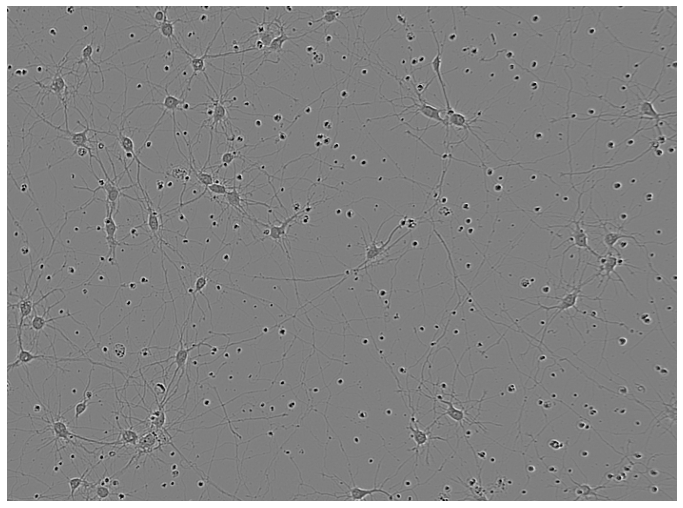

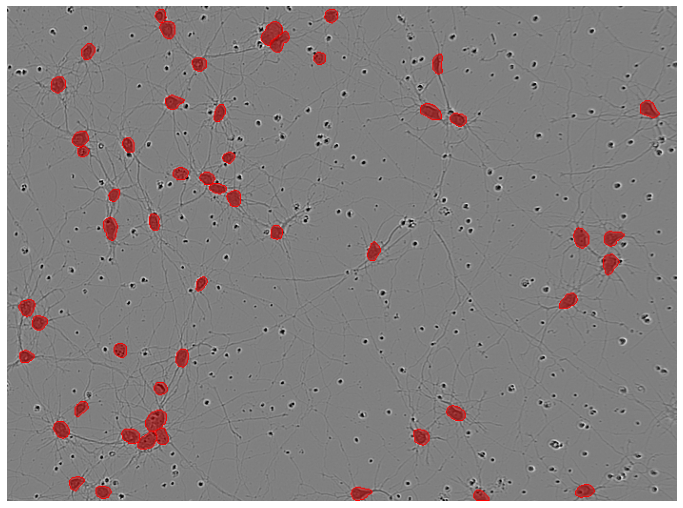

In [42]:
import matplotlib.pyplot as plt
import cv2

color_list = [
              (0, 255, 0),
              (255, 0, 0),
              (0, 0, 255)
]

# 원본 이미지 시각화 
image_array = cv2.cvtColor(cv2.imread(os.path.join('/content/cell/train', img['file_name'] + '.png')), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 14))
plt.imshow(image_array)
plt.axis('off')

# coco segmentation 정보를 기반으로 segmentation 적용한 이미지 시각화 
masked_image = draw_segment(image_array, ann_seg_list, ann_cat_list, color_list, alpha=0.6)
plt.figure(figsize=(12, 14))
plt.imshow(masked_image)
plt.axis('off')

## Pretrained 모델 다운로드, Config 설정

In [43]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬
%cd mmdetection
!mkdir checkpoints

/content/mmdetection


In [46]:
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2022-02-20 17:30:45--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’

/content/mmdetectio 100%[===================>] 242.32M  3.78MB/s    in 41s     

2022-02-20 17:31:27 (5.88 MB/s) - ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’ saved [254089599/254089599]



In [47]:
!ls -lia /content/mmdetection/checkpoints

total 248148
5249270 drwxr-xr-x  2 root root      4096 Feb 20 17:30 .
5243025 drwxr-xr-x 19 root root      4096 Feb 20 17:30 ..
5249271 -rw-r--r--  1 root root 254089599 Nov  2 16:37 mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


In [48]:
# config 파일 설정, 다운로드 받은 pretrained 모델을 checkpoint로 설정.
config_file = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [50]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

# CellDataset을 레지스터에 등록
@DATASETS.register_module(force = True)
class CellDataset(CocoDataset):
  CLASSES = ('shsy5y', 'cort', 'astro')

In [76]:
from mmcv import Config
cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [77]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정
cfg.dataset_type = 'CellDataset'
cfg.data_root = '/content/cell'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'CellDataset'
cfg.data.train.data_root = '/content/cell'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'train'

cfg.data.val.type = 'CellDataset'
cfg.data.val.data_root = '/content/cell'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'val'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 3
cfg.model.roi_head.mask_head.num_classes = 3

# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = '/content/drive/MyDrive/Cell-Segmentation'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# epochs 횟수는 36으로 증가 
cfg.runner.max_epochs = 36

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 학습수행

In [78]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train 용 Dataset 생성
dataset = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!


In [79]:
dataset[0]


CellDataset Train dataset with number of images 545, and instance counts: 
+------------+-------+----------+-------+-----------+-------+----------+-------+----------+-------+
| category   | count | category | count | category  | count | category | count | category | count |
+------------+-------+----------+-------+-----------+-------+----------+-------+----------+-------+
|            |       |          |       |           |       |          |       |          |       |
| 0 [shsy5y] | 47540 | 1 [cort] | 10017 | 2 [astro] | 13971 |          |       |          |       |
+------------+-------+----------+-------+-----------+-------+----------+-------+----------+-------+

In [80]:
model = build_detector(cfg.model, train_cfg = cfg.get('train_cfg'), test_cfg = cfg.get('test_cfg'))
model.CLASSES = dataset[0].CLASSES
print(model.CLASSES)

('shsy5y', 'cort', 'astro')


In [81]:
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_detector(model, dataset, cfg, distributed = False, validate = True)

2022-02-20 17:55:22,716 - mmdet - INFO - load checkpoint from local path: /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


2022-02-20 17:55:22,973 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([12]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits.bi

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 4.6 task/s, elapsed: 13s, ETA:     0s

2022-02-20 19:33:04,595 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-02-20 19:33:27,505 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.398
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.253
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=22.73s).
Accumulating evaluation results...
DONE (t=0.14s).
Loading and preparing results...


/usr/local/lib/python3.7/dist-packages/mmdet-2.21.0-py3.7.egg/mmdet/datasets/coco.py:478: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-02-20 19:33:51,063 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.393
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=23.31s).
Accumulating evaluation results...
DONE (t=0.14s).


2022-02-20 19:34:18,806 - mmdet - INFO - Epoch [13][10/273]	lr: 2.500e-05, eta: 3:12:56, time: 2.765, data_time: 1.926, memory: 10161, loss_rpn_cls: 0.0878, loss_rpn_bbox: 0.1674, loss_cls: 0.3365, acc: 86.3867, loss_bbox: 0.4565, loss_mask: 0.3046, loss: 1.3528
2022-02-20 19:34:34,512 - mmdet - INFO - Epoch [13][20/273]	lr: 2.500e-05, eta: 3:12:35, time: 1.571, data_time: 0.885, memory: 10161, loss_rpn_cls: 0.0520, loss_rpn_bbox: 0.1442, loss_cls: 0.2910, acc: 87.7539, loss_bbox: 0.4476, loss_mask: 0.2968, loss: 1.2316
2022-02-20 19:34:56,736 - mmdet - INFO - Epoch [13][30/273]	lr: 2.500e-05, eta: 3:12:26, time: 2.222, data_time: 1.430, memory: 10161, loss_rpn_cls: 0.0786, loss_rpn_bbox: 0.1600, loss_cls: 0.3096, acc: 86.7285, loss_bbox: 0.4624, loss_mask: 0.3128, loss: 1.3234
2022-02-20 19:35:13,057 - mmdet - INFO - Epoch [13][40/273]	lr: 2.500e-05, eta: 3:12:05, time: 1.632, data_time: 0.892, memory: 10161, loss_rpn_cls: 0.0597, loss_rpn_bbox: 0.1501, loss_cls: 0.2909, acc: 87.6562,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 4.7 task/s, elapsed: 13s, ETA:     0s

2022-02-20 21:10:13,572 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-02-20 21:10:37,173 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.400
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=23.43s).
Accumulating evaluation results...
DONE (t=0.13s).
Loading and preparing results...


/usr/local/lib/python3.7/dist-packages/mmdet-2.21.0-py3.7.egg/mmdet/datasets/coco.py:478: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-02-20 21:10:59,521 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.394
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=22.12s).
Accumulating evaluation results...
DONE (t=0.13s).


2022-02-20 21:11:25,642 - mmdet - INFO - Epoch [25][10/273]	lr: 2.500e-05, eta: 1:35:36, time: 2.605, data_time: 1.815, memory: 10161, loss_rpn_cls: 0.0848, loss_rpn_bbox: 0.1659, loss_cls: 0.3005, acc: 87.0801, loss_bbox: 0.4571, loss_mask: 0.3184, loss: 1.3267
2022-02-20 21:11:46,445 - mmdet - INFO - Epoch [25][20/273]	lr: 2.500e-05, eta: 1:35:20, time: 2.080, data_time: 1.289, memory: 10161, loss_rpn_cls: 0.0682, loss_rpn_bbox: 0.1493, loss_cls: 0.2978, acc: 87.3047, loss_bbox: 0.4209, loss_mask: 0.3026, loss: 1.2388
2022-02-20 21:12:01,571 - mmdet - INFO - Epoch [25][30/273]	lr: 2.500e-05, eta: 1:35:01, time: 1.513, data_time: 0.844, memory: 10161, loss_rpn_cls: 0.0494, loss_rpn_bbox: 0.1369, loss_cls: 0.2529, acc: 89.7852, loss_bbox: 0.4236, loss_mask: 0.2968, loss: 1.1596
2022-02-20 21:12:13,679 - mmdet - INFO - Epoch [25][40/273]	lr: 2.500e-05, eta: 1:34:41, time: 1.210, data_time: 0.541, memory: 10161, loss_rpn_cls: 0.0499, loss_rpn_bbox: 0.1407, loss_cls: 0.2622, acc: 89.3262,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 4.5 task/s, elapsed: 14s, ETA:     0s

2022-02-20 22:48:12,318 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-02-20 22:48:36,172 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.398
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=23.66s).
Accumulating evaluation results...
DONE (t=0.13s).
Loading and preparing results...


/usr/local/lib/python3.7/dist-packages/mmdet-2.21.0-py3.7.egg/mmdet/datasets/coco.py:478: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-02-20 22:48:58,900 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.395
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=22.49s).
Accumulating evaluation results...
DONE (t=0.14s).
